In [1]:
import pandas as pd
import numpy as np
import latex
# import seaborn as sns

In [2]:
# making plots look good
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['text.usetex'] = False
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 14, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1.5,'xtick.labelsize':14})

cm = 1/2.54
H = 14.56
W = 9

# Lexical: phones + phones with space
# fig, ax = plt.subplots(1,1, figsize=(H*cm,W*cm), constrained_layout=True)

## Plot parameters

In [3]:
METRIC_NAMES = {
    "ValidationMetric": "(mae(snr)+mae(c50)+(1-fscore(vad))/3",
    # "ValidationMetric": r'\frac{(1-F-score(VAD))+NMAE(SNR)+NMAE(C50)}{3}',
    "c50ValMetric": "C50 MAE",
    "snrValMetric": "SNR MAE",
    "vadValMetric": "VAD F-score"
}
METRICS = [
    "ValidationMetric",
    "c50ValMetric",
    "snrValMetric",
    "vadValMetric"
]
PARAMS = [
    "dropout",
    "duration",
    "batch_size",
    "hidden_size",
    "num_layers"
]
PARAMS_NAMES = {
    "dropout": "Dropout",
    "duration": "Duration (s)",
    "batch_size": "Batch size",
    "hidden_size": "LSTM Hidden size",
    "num_layers": "Number of LSTM layers"
}

In [4]:
#on orignal gridsearch
PARAMS_PLOT_ORIGINAL = {
    "vadValMetric": {
        "ratio": 500,
        "scattering": 0.119,
        "widths": 0.5
    },
    "ValidationMetric": {
        "ratio": 220,
        "scattering": 0.095,
        "widths": 0.5
    },
    "c50ValMetric": {
        "ratio": 2.2,
        "scattering": 0.122,
        "widths": 0.5
    },
    "snrValMetric": {
        "ratio": 3,
        "scattering": 0.095,
        "widths": 0.5
    }
}

# on heldout
PARAMS_PLOT_HELDOUT = {
    "vadValMetric": {
        "ratio": 0.7,
        "scattering": 0.122,
        "widths": 0.5
    },
    "ValidationMetric": {
        "ratio": 120,
        "scattering": 0.095,
        "widths": 0.5
    },
    "c50ValMetric": {
        "ratio": 1,
        "scattering": 0.122,
        "widths": 0.5
    },
    "snrValMetric": {
        "ratio": 1.1,
        "scattering": 0.115,
        "widths": 0.5
    }
}

# on dev
PARAMS_PLOT_DEV = {
    "vadValMetric": {
        "ratio": 3.5,
        "scattering": 0.099,
        "widths": 0.5
    },
    "ValidationMetric": {
        "ratio": 400,
        "scattering": 0.095,
        "widths": 0.5
    },
    "c50ValMetric": {
        "ratio": 4,
        "scattering": 0.12,
        "widths": 0.5
    },
    "snrValMetric": {
        "ratio": 3.5,
        "scattering": 0.115,
        "widths": 0.5
    }
}

def params_plot(dataset_name):
    if dataset_name == "original":
        return PARAMS_PLOT_ORIGINAL
    if dataset_name == "dev":
        return PARAMS_PLOT_DEV
    elif dataset_name == "heldout":
        return PARAMS_PLOT_HELDOUT



## Load the data

In [5]:
data_heldout = pd.read_csv("csv_files/gridsearch_on_heldout.csv", index_col=0)
data_heldout_all = data_heldout[data_heldout["only_vad"]==False].reset_index(drop=True)
data_heldout_only_vad = data_heldout[data_heldout["only_vad"]==True].reset_index(drop=True)
data_heldout.head()

,duration,batch_size,hidden_size,num_layers,dropout,stride,snrValMetric,c50ValMetric,vadValMetric,ValidationMetric,name,only_vad
0,6,128,128,3,0.3,10,29.751545,15.129447,82.592551,0.234461,dur_6_bs_128_lstm_hs_128_lstm_nl_3_dropout_0.3...,True
1,2,128,128,3,0.5,10,22.801720,15.260587,79.427751,0.221250,dur_2_bs_128_lstm_hs_128_lstm_nl_3_dropout_0.5...,True
2,10,64,256,2,0.5,10,22.383507,7.622243,82.111823,0.174462,dur_10_bs_64_lstm_hs_256_lstm_nl_2_dropout_0.5,False
3,8,32,256,3,0.3,10,22.599873,7.886026,81.609691,0.178151,dur_8_bs_32_lstm_hs_256_lstm_nl_3_dropout_0.3,False
4,10,64,256,2,0.3,10,22.660259,7.475838,81.488064,0.176815,dur_10_bs_64_lstm_hs_256_lstm_nl_2_dropout_0.3,False


In [6]:
# load csv with all the data
data = pd.read_csv("csv_files/gridsearch_data.csv", index_col=0)
data_all = data[data["only_vad"]==False].reset_index(drop=True)
data_only_vad = data[data["only_vad"]==True].reset_index(drop=True)
data.head()

,duration,batch_size,hidden_size,num_layers,dropout,stride,c50ValMetric,snrValMetric,vadOptiTh,vadValMetric,ValidationMetric,TrainLoss,vadLoss,snrLoss,c50Loss,best_epoch,name,only_vad
0,6,128,128,3,0.3,10,17.057028,40.007397,0.46,0.982131,0.017102,0.078228,0.078229,1.537775,1.019147,32.0,dur_6_bs_128_lstm_hs_128_lstm_nl_3_dropout_0.3...,True
1,10,64,256,2,0.5,10,3.734159,4.361837,0.40,0.983320,0.038421,0.212127,0.077840,0.088764,0.045523,17.0,dur_10_bs_64_lstm_hs_256_lstm_nl_2_dropout_0.5,False
2,8,32,256,3,0.3,10,3.894238,4.385685,0.44,0.983881,0.038807,0.206240,0.075879,0.091677,0.038684,28.0,dur_8_bs_32_lstm_hs_256_lstm_nl_3_dropout_0.3,False
3,10,64,256,2,0.3,10,3.898918,4.272216,0.38,0.984408,0.038530,0.184144,0.073910,0.077824,0.032410,31.0,dur_10_bs_64_lstm_hs_256_lstm_nl_2_dropout_0.3,False
4,8,128,256,2,0.3,10,30.752617,19.893839,0.44,0.984784,0.014708,0.068120,0.068120,1.487232,2.621930,32.0,dur_8_bs_128_lstm_hs_256_lstm_nl_2_dropout_0.3...,True


In [7]:
# load csv with all the data
data_on_dev = pd.read_csv("csv_files/gridsearch_data_on_dev.csv", index_col=0)
data_on_dev = pd.merge(data_on_dev, data[["name", "best_epoch"]], on="name")
data_on_dev_all = data_on_dev[data_on_dev["only_vad"]==False].reset_index(drop=True)
data_on_dev_only_vad = data_on_dev[data_on_dev["only_vad"]==True].reset_index(drop=True)
data_on_dev.head()

,duration,batch_size,hidden_size,num_layers,dropout,stride,ValidationMetric,c50ValMetric,snrValMetric,vadValMetric,name,only_vad,best_epoch
0,6,128,128,3,0.3,10,0.246513,16.115791,42.231064,93.522369,dur_6_bs_128_lstm_hs_128_lstm_nl_3_dropout_0.3...,True,32.0
1,10,64,256,2,0.5,10,0.057153,4.662999,4.264355,94.004454,dur_10_bs_64_lstm_hs_256_lstm_nl_2_dropout_0.5,False,17.0
2,8,32,256,3,0.3,10,0.056725,4.553008,4.121862,93.825684,dur_8_bs_32_lstm_hs_256_lstm_nl_3_dropout_0.3,False,28.0
3,10,64,256,2,0.3,10,0.057558,4.821890,4.184924,94.026338,dur_10_bs_64_lstm_hs_256_lstm_nl_2_dropout_0.3,False,31.0
4,8,128,256,2,0.3,10,0.232189,26.550629,24.291164,93.842507,dur_8_bs_128_lstm_hs_256_lstm_nl_2_dropout_0.3...,True,32.0


## Plot the gridsearch figures

In [8]:
def scattered_boxplot(
    data: pd.DataFrame,
    param_to_monitor: str = "dropout",
    metric: str = 'ValidationMetric',
    figure_path: str = None,
    dataset_name: str = "original",
    save: bool = True
) -> None:

    PARAMS_PLOT = params_plot(dataset_name)
    
    ratio = PARAMS_PLOT[metric]["ratio"]
    scattering = PARAMS_PLOT[metric]["scattering"]
    widths = PARAMS_PLOT[metric]["widths"]

    print(f"ratio : {ratio}")
    print(f"scattering : {scattering}")
    print(f"widths : {widths}")

    possible_values = np.sort(data[param_to_monitor].unique())
    if metric == "vadValMetric":
        coef = 1
    else:
        coef = 1

    values = dict()
    for value in possible_values:
        values[value] = data[data[param_to_monitor] == value][metric].reset_index(drop=True) * coef

    default_arch = data[data["name"] == 'dur_2_bs_32_lstm_hs_128_lstm_nl_2_dropout_0']
    val_default_arch = default_arch[metric] * coef

    vals, names, xs = [],[],[]
    for i, col in enumerate(values.keys()):
        vals.append(values[col])
        names.append(col)
        xs.append(np.random.normal(i + 1, scattering, len(values[col])))
        # adds jitter to the data points - can be adjusted

    fig, ax = plt.subplots(1,1, figsize=(H*cm,W*cm), constrained_layout=True)
    ax.set_aspect(ratio)

    ax.boxplot(vals, labels=names, widths=widths)
    palette = ['r', 'g', 'b', 'y', 'm']
    markers = ['.', '^', 'x', '*', 'p']
    for x, val, c, m in zip(xs, vals, palette, markers):
        ax.scatter(x, val, alpha=0.5, color=c, marker=m, s=60)

    # y axis
    plt.xlabel(param_to_monitor.replace('_', ' ').capitalize(), fontweight='normal', fontsize=14)
    plt.ylabel(METRIC_NAMES[metric], fontweight='normal', fontsize=14)

    # default architecture
    # ax.axhline(y=float(val_default_arch), color='k', linestyle='--', alpha=0.7, linewidth=3, label='Default arch.')
    # ax.legend(bbox_to_anchor=(0.05, 1.15), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)

    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    if not figure_path:
        figure_path = f"figures/figures_{dataset_name}/{param_to_monitor}_{metric}.png"
    if save:
        plt.savefig(figure_path, bbox_inches="tight")#, dpi=300)

ratio : 220
scattering : 0.095
widths : 0.5


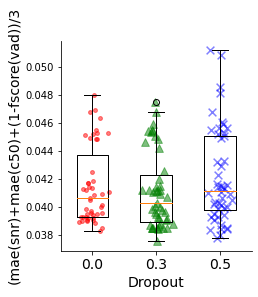

In [9]:
# One example of scattered boxplot
scattered_boxplot(data_all, metric="ValidationMetric", save=False)

ratio : 120
scattering : 0.095
widths : 0.5
ratio : 120
scattering : 0.095
widths : 0.5
ratio : 120
scattering : 0.095
widths : 0.5
ratio : 120
scattering : 0.095
widths : 0.5
ratio : 120
scattering : 0.095
widths : 0.5
ratio : 1
scattering : 0.122
widths : 0.5
ratio : 1
scattering : 0.122
widths : 0.5
ratio : 1
scattering : 0.122
widths : 0.5
ratio : 1
scattering : 0.122
widths : 0.5
ratio : 1
scattering : 0.122
widths : 0.5
ratio : 1.1
scattering : 0.115
widths : 0.5
ratio : 1.1
scattering : 0.115
widths : 0.5
ratio : 1.1
scattering : 0.115
widths : 0.5
ratio : 1.1
scattering : 0.115
widths : 0.5
ratio : 1.1
scattering : 0.115
widths : 0.5
ratio : 0.7
scattering : 0.122
widths : 0.5
ratio : 0.7
scattering : 0.122
widths : 0.5
ratio : 0.7
scattering : 0.122
widths : 0.5
ratio : 0.7
scattering : 0.122
widths : 0.5
ratio : 0.7
scattering : 0.122
widths : 0.5


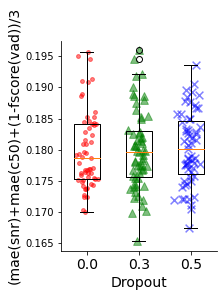

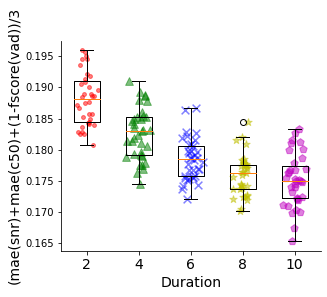

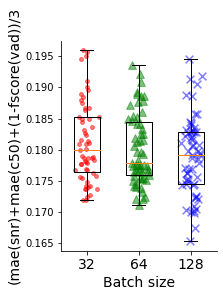

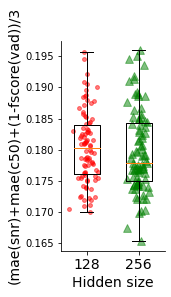

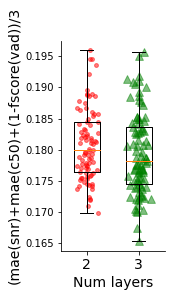

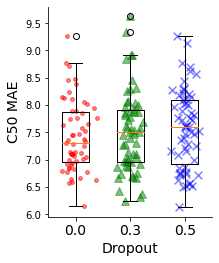

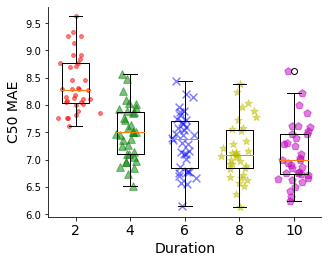

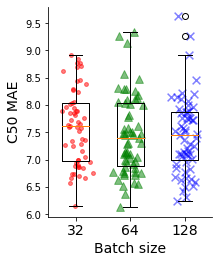

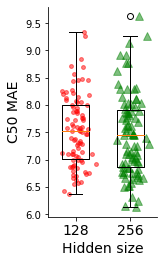

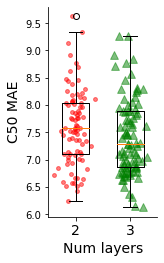

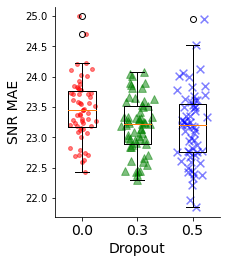

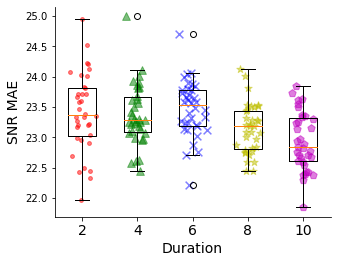

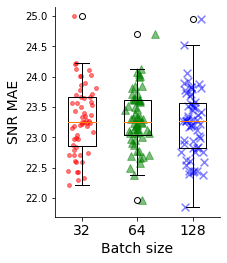

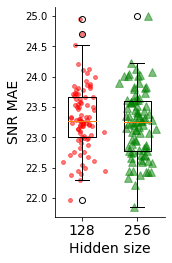

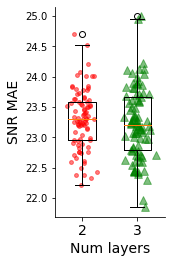

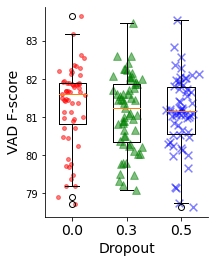

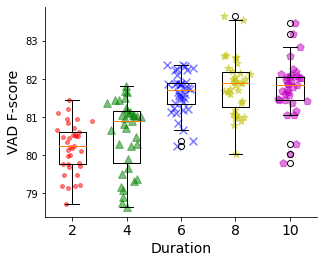

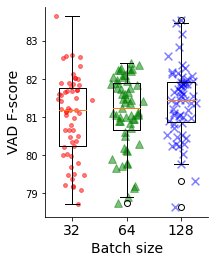

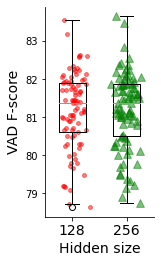

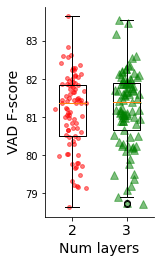

In [10]:
# generate all plots
for metric in METRICS:
    for param in PARAMS:
        scattered_boxplot(data_heldout_all, param, metric, dataset_name="heldout")

ratio : 400
scattering : 0.095
widths : 0.5
ratio : 400
scattering : 0.095
widths : 0.5
ratio : 400
scattering : 0.095
widths : 0.5
ratio : 400
scattering : 0.095
widths : 0.5
ratio : 400
scattering : 0.095
widths : 0.5
ratio : 4
scattering : 0.12
widths : 0.5
ratio : 4
scattering : 0.12
widths : 0.5
ratio : 4
scattering : 0.12
widths : 0.5
ratio : 4
scattering : 0.12
widths : 0.5
ratio : 4
scattering : 0.12
widths : 0.5
ratio : 3.5
scattering : 0.115
widths : 0.5
ratio : 3.5
scattering : 0.115
widths : 0.5
ratio : 3.5
scattering : 0.115
widths : 0.5
ratio : 3.5
scattering : 0.115
widths : 0.5
ratio : 3.5
scattering : 0.115
widths : 0.5
ratio : 3.5
scattering : 0.099
widths : 0.5
ratio : 3.5
scattering : 0.099
widths : 0.5
ratio : 3.5
scattering : 0.099
widths : 0.5
ratio : 3.5
scattering : 0.099
widths : 0.5
ratio : 3.5
scattering : 0.099
widths : 0.5


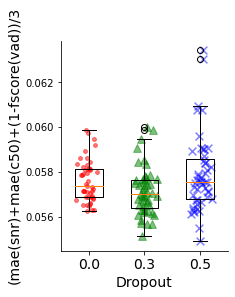

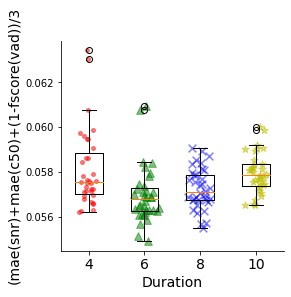

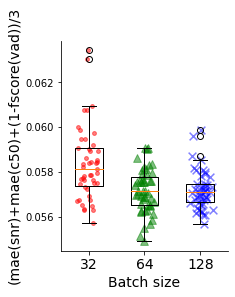

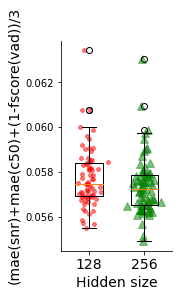

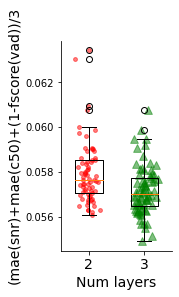

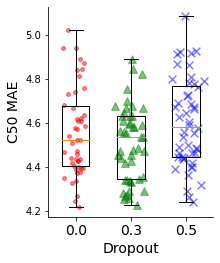

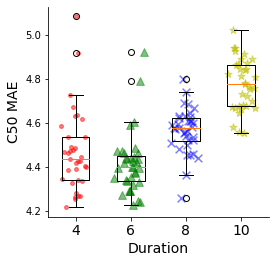

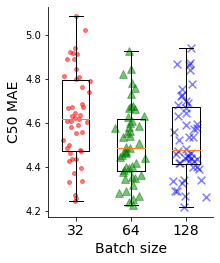

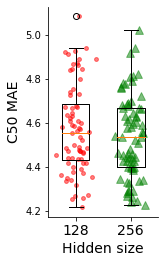

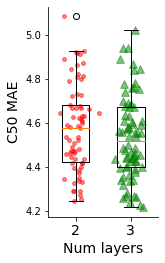

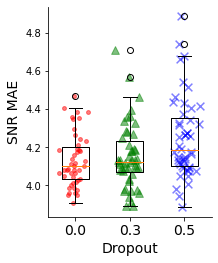

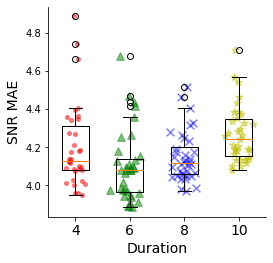

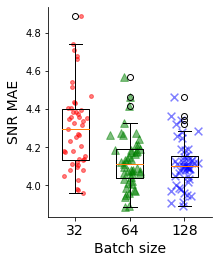

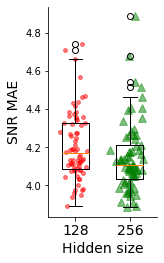

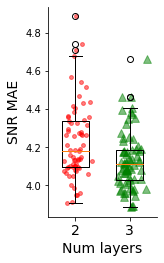

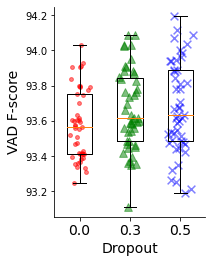

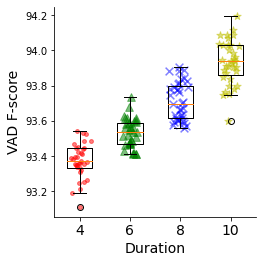

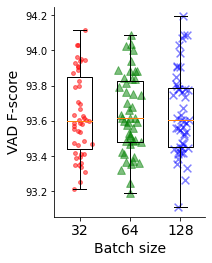

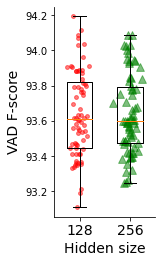

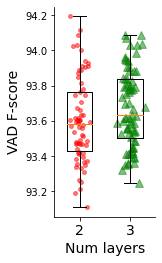

In [11]:
# generate all plots
for metric in METRICS:
    for param in PARAMS:
        scattered_boxplot(data_on_dev_all, param, metric, dataset_name="dev")

ratio : 220
scattering : 0.095
widths : 0.5
ratio : 220
scattering : 0.095
widths : 0.5
ratio : 220
scattering : 0.095
widths : 0.5
ratio : 220
scattering : 0.095
widths : 0.5
ratio : 220
scattering : 0.095
widths : 0.5
ratio : 2.2
scattering : 0.122
widths : 0.5
ratio : 2.2
scattering : 0.122
widths : 0.5
ratio : 2.2
scattering : 0.122
widths : 0.5
ratio : 2.2
scattering : 0.122
widths : 0.5
ratio : 2.2
scattering : 0.122
widths : 0.5
ratio : 3
scattering : 0.095
widths : 0.5
ratio : 3
scattering : 0.095
widths : 0.5
ratio : 3
scattering : 0.095
widths : 0.5
ratio : 3
scattering : 0.095
widths : 0.5
ratio : 3
scattering : 0.095
widths : 0.5
ratio : 500
scattering : 0.119
widths : 0.5
ratio : 500
scattering : 0.119
widths : 0.5
ratio : 500
scattering : 0.119
widths : 0.5
ratio : 500
scattering : 0.119
widths : 0.5
ratio : 500
scattering : 0.119
widths : 0.5


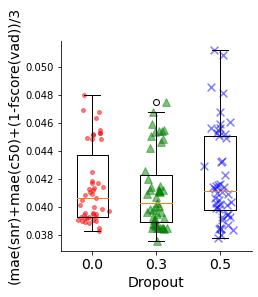

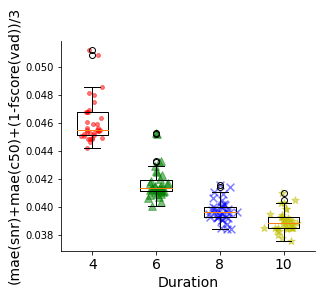

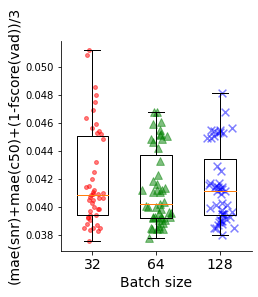

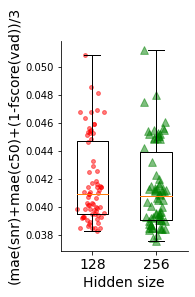

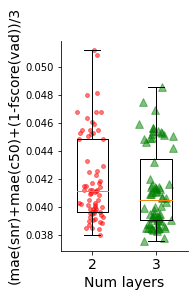

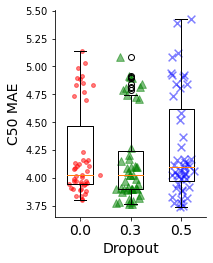

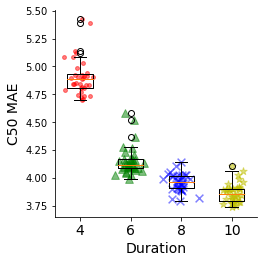

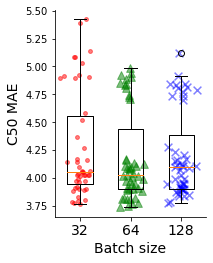

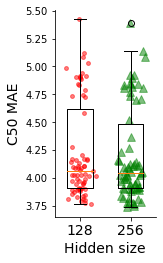

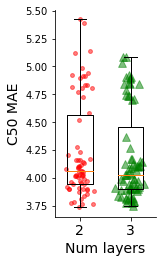

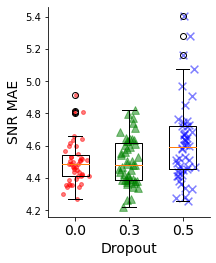

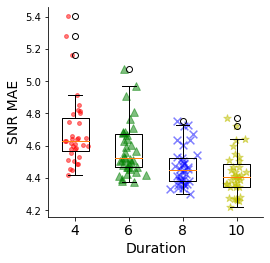

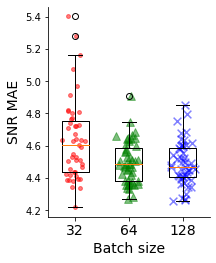

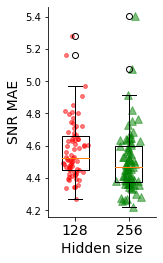

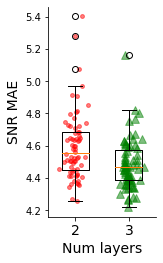

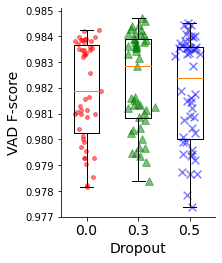

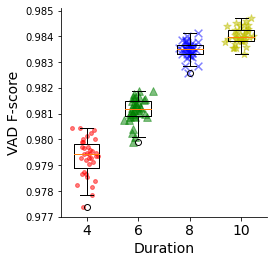

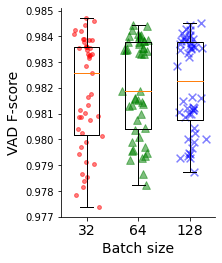

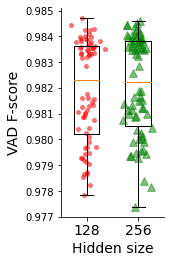

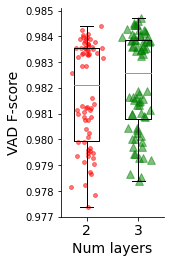

In [12]:
# generate all plots
for metric in METRICS:
    for param in PARAMS:
        scattered_boxplot(data_all, param, metric, dataset_name="original")

## Find the best model and epoch

In [13]:
def best_models(data):
    metrics_min = ["ValidationMetric", "snrValMetric", "c50ValMetric"]
    metrics_max = ["vadValMetric"]
    best = dict()
    for metric in metrics_min:
        index = data[metric].idxmin()
        values = {
            "model": data.iloc[index]['name'],
            "value": data.iloc[index][metric]
        }
        best[metric] = values

    for metric in metrics_max:
        index = data[metric].idxmax()
        values = {
            "model": data.iloc[index]['name'],
            "value": data.iloc[index][metric]
        }
        best[metric] = values

    return best

In [14]:
def print_best_model_values(data):
    best_mod = best_models(data)
    best = data[data["name"] == best_mod["ValidationMetric"]["model"]]
    for key, values in best_mod.items():
        print(f"Best model for {key}: {values['model']}, with value {values['value']}")
    # print(best_mod)
    print(f"\nFor the best model {best_mod['ValidationMetric']['model']}")
    print(f"\tbest epoch : {best['best_epoch'].iloc[0]}")
    # print(f"\toptimal threshold : {best['vadOptiTh'].iloc[0]}")

#### On tensorboard data

In [15]:
print_best_model_values(data_all)

Best model for ValidationMetric: dur_10_bs_32_lstm_hs_256_lstm_nl_3_dropout_0.3, with value 0.0375582799315452
Best model for snrValMetric: dur_10_bs_32_lstm_hs_256_lstm_nl_3_dropout_0.3, with value 4.2186598777771
Best model for c50ValMetric: dur_10_bs_64_lstm_hs_256_lstm_nl_2_dropout_0.5, with value 3.734159469604492
Best model for vadValMetric: dur_10_bs_32_lstm_hs_128_lstm_nl_3_dropout_0.3, with value 0.98473459482193

For the best model dur_10_bs_32_lstm_hs_256_lstm_nl_3_dropout_0.3
	best epoch : 31.0


#### On dev data

In [16]:
best_mod = best_models(data_on_dev_all)
best = data[data["name"] == best_mod["ValidationMetric"]["model"]]
for key, values in best_mod.items():
    print(f"Best model for {key}: {values['model']}, with value {values['value']}")
# print(best_mod)
print(f"\nFor the best model {best_mod['ValidationMetric']['model']}")
print(f"\tbest epoch : {best['best_epoch'].iloc[0]}")
# print(f"\toptimal threshold : {best['vadOptiTh'].iloc[0]}")

Best model for ValidationMetric: dur_6_bs_64_lstm_hs_256_lstm_nl_3_dropout_0.5, with value 0.0548936278251687
Best model for snrValMetric: dur_6_bs_64_lstm_hs_256_lstm_nl_3_dropout_0.5, with value 3.884775161743164
Best model for c50ValMetric: dur_4_bs_128_lstm_hs_128_lstm_nl_3_dropout_0, with value 4.216771125793457
Best model for vadValMetric: dur_10_bs_128_lstm_hs_128_lstm_nl_2_dropout_0.5, with value 94.1944749689174

For the best model dur_6_bs_64_lstm_hs_256_lstm_nl_3_dropout_0.5
	best epoch : 32.0


## Experiments with only_vad vs with the ones with vad, SNR and C50 predictions

In [17]:
relevant_columns = ["duration", "batch_size", "hidden_size", "num_layers", "dropout", "name", "vadValMetric"]
df_1 = data_on_dev_only_vad[relevant_columns]
df_2 = data_on_dev_all[relevant_columns]
matched_final = pd.merge(df_1, df_2, on=["duration", "batch_size", "hidden_size", "num_layers", "dropout"], suffixes=("_only_vad", "_all"))
matched_final.head()

,duration,batch_size,hidden_size,num_layers,dropout,name_only_vad,vadValMetric_only_vad,name_all,vadValMetric_all
0,6,128,128,3,0.3,dur_6_bs_128_lstm_hs_128_lstm_nl_3_dropout_0.3...,93.522369,dur_6_bs_128_lstm_hs_128_lstm_nl_3_dropout_0.3,93.733880
1,8,128,256,2,0.3,dur_8_bs_128_lstm_hs_256_lstm_nl_2_dropout_0.3...,93.842507,dur_8_bs_128_lstm_hs_256_lstm_nl_2_dropout_0.3,93.747251
2,4,64,256,3,0.0,dur_4_bs_64_lstm_hs_256_lstm_nl_3_dropout_0_on...,93.351353,dur_4_bs_64_lstm_hs_256_lstm_nl_3_dropout_0,93.246569
3,8,128,256,3,0.5,dur_8_bs_128_lstm_hs_256_lstm_nl_3_dropout_0.5...,93.798566,dur_8_bs_128_lstm_hs_256_lstm_nl_3_dropout_0.5,93.780484
4,6,128,256,2,0.0,dur_6_bs_128_lstm_hs_256_lstm_nl_2_dropout_0_o...,93.655323,dur_6_bs_128_lstm_hs_256_lstm_nl_2_dropout_0,93.568143


In [18]:
all_fscore = pd.DataFrame.from_records(matched_final[["vadValMetric_all", "duration"]])
only_vad_fscore = pd.DataFrame(matched_final[["vadValMetric_only_vad", "duration"]])
all_fscore.rename(columns={"vadValMetric_all": "vadValMetric"}, inplace=True)
only_vad_fscore.rename(columns={"vadValMetric_only_vad": "vadValMetric"}, inplace=True)

In [19]:
def scattered_boxplot_linked(condition_1, condition_2, names, title, output=None):
    vals, xs = [],[]
    cols = [condition_1, condition_2]

    for i, col in enumerate(cols):
        vals.append(col)
        xs.append(np.random.normal(i + 1, 0.04, len(col)))
    colors = ["red" if mid < dist else "green" for mid,dist in zip(vals[0], vals[1])]

    plt.figure(figsize=(13,13))

    for i in range(len(vals[1])):
        plt.plot([xs[0][i],xs[1][i]], [vals[0][i],vals[1][i]], color=colors[i], alpha=0.1)
        
    plt.boxplot(vals, labels=names, showfliers=False)
    palette = ['black', 'black']
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.4, color=c, s=0.5)
    
    print(f"red proportion : {colors.count('red')/len(colors)}")
    print(f"green proportion : {colors.count('green')/len(colors)}")

    plt.ylabel('F-score')
    plt.title(title)
    plt.savefig(output)

In [20]:
def scattered_boxplot_linked_by_duration(condition_1, condition_2, names, title, output=None):
    fig, axes = plt.subplots(2,2, figsize=(17,17))

    durations = [4, 6, 8, 10]
    ax = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]

    for dur, axe in zip(durations, ax):
        vals, xs = [],[]
        cond_1 = condition_1[condition_1.duration == dur]
        cond_2 = condition_2[condition_2.duration == dur]
        cols = [cond_1["vadValMetric"].tolist(), cond_2["vadValMetric"].tolist()]

        for i, col in enumerate(cols):
            vals.append(col)
            xs.append(np.random.normal(i + 1, 0.04, len(col)))
        colors = ["red" if mid < dist else "green" for mid,dist in zip(vals[0], vals[1])]

        for i in range(len(vals[1])):
            axe.plot([xs[0][i],xs[1][i]], [vals[0][i],vals[1][i]], color=colors[i], alpha=0.1)
            
        axe.boxplot(vals, labels=names, showfliers=False)
        palette = ['black', 'black']
        for x, val, c in zip(xs, vals, palette):
            axe.scatter(x, val, alpha=0.4, color=c, s=0.5)
        axe.set(ylabel='F-score')
        axe.title.set_text(f"Duration = {dur} seconds")

        print(f"duration = {dur} seconds")
        print(f"red proportion : {colors.count('red')/len(colors)}")
        print(f"green proportion : {colors.count('green')/len(colors)}")

    # plt.title(title)
    plt.savefig(output)

duration = 4 seconds
red proportion : 0.4857142857142857
green proportion : 0.5142857142857142
duration = 6 seconds
red proportion : 0.6
green proportion : 0.4
duration = 8 seconds
red proportion : 0.6111111111111112
green proportion : 0.3888888888888889
duration = 10 seconds
red proportion : 0.2571428571428571
green proportion : 0.7428571428571429


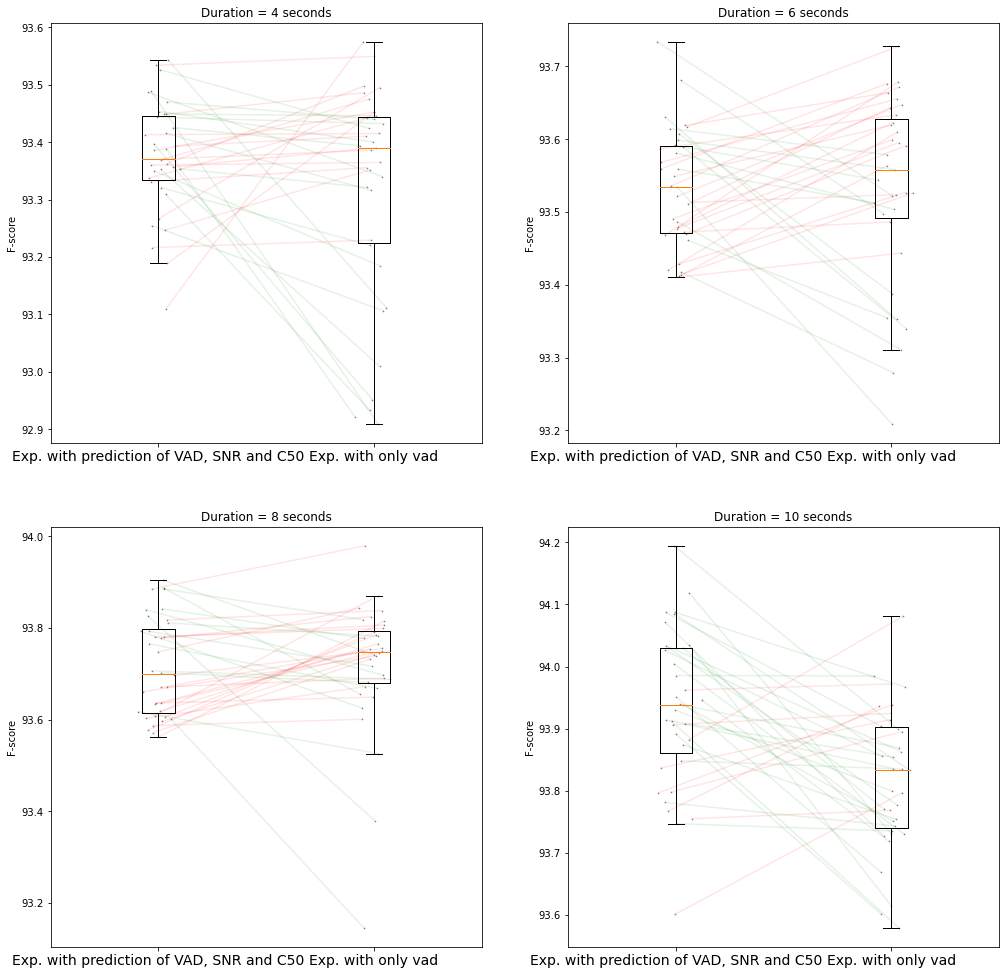

In [21]:
scattered_boxplot_linked_by_duration(
    all_fscore,
    only_vad_fscore,
    ["Exp. with prediction of VAD, SNR and C50", "Exp. with only vad"],
    "F-score on dev set",
    output="figures/vad_vs_snr_c50_vad/linked_fscore_by_duration.png"
)

red proportion : 0.48936170212765956
green proportion : 0.5106382978723404


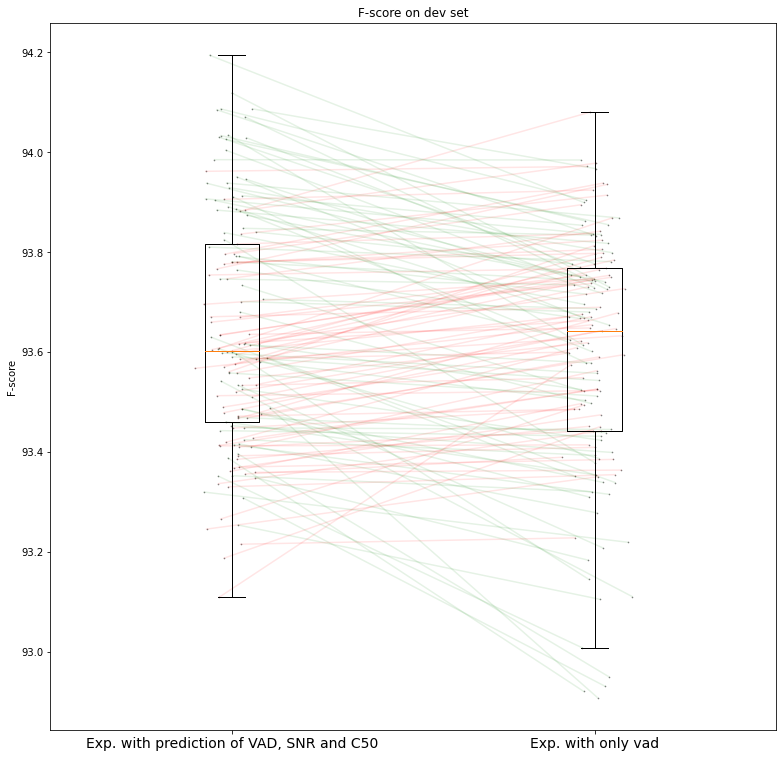

In [22]:
all_fscore_vad = all_fscore["vadValMetric"]
only_vad_fscore_vad = only_vad_fscore["vadValMetric"]
scattered_boxplot_linked(
    all_fscore_vad,
    only_vad_fscore_vad,
    ["Exp. with prediction of VAD, SNR and C50", "Exp. with only vad"],
    "F-score on dev set",
    output="figures/vad_vs_snr_c50_vad/linked_fscore.png"
)